# Tutorial 2: Inside CrypTensors

Note: This tutorial is optional, and can be skipped without any loss of continuity to the following tutorials.


In this tutorial, we will take a brief look at the internals of ```CrypTensors```. 

Using the `mpc` backend, a `CrypTensor` is a tensor encrypted using secure MPC protocols, called an `MPCTensor`. In order to support the mathematical operations required by the `MPCTensor`, CrypTen implements two kinds of secret-sharing protocols: arithmetic secret-sharing and binary secret-sharing. Arithmetic secret sharing forms the basis for most of the mathematical operations implemented by `MPCTensor`. Similarly, binary secret-sharing allows for the evaluation of logical expressions.

In this tutorial, we'll first introduce the concept of a `CrypTensor` <i>ptype</i> (i.e. <i>private-type</i>), and show how to use it to obtain `MPCTensors` that use arithmetic and binary secret shares. We will also describe how each of these <i>ptypes</i> is used, and how they can be combined to implement desired functionality.

In [1]:
#import the libraries
import torch
import crypten

#initialize crypten
crypten.init()
#Disables OpenMP threads -- needed by @mpc.run_multiprocess which uses fork
torch.set_num_threads(1)

## <i>ptype</i> in CrypTen
CrypTen defines the `ptype` (for <i>private-type</i>) attribute of an `MPCTensor` to denote the kind of secret-sharing protocol used in the `CrypTensor`. The `ptype` is, in many ways, analogous to the `dtype` of PyTorch. The `ptype` may have two values: 

- `crypten.mpc.arithmetic` for `ArithmeticSharedTensors`</li>
- `crypten.mpc.binary` for  `BinarySharedTensors`</li>

We can use the `ptype` attribute to create a `CrypTensor` with the appropriate secret-sharing protocol. For example: 

In [13]:
#Constructing CrypTensors with ptype attribute

#arithmetic secret-shared tensors
x_enc = crypten.cryptensor([1, 2, 3], precision=None, ptype=crypten.mpc.arithmetic)
print("x_enc internal type:", x_enc.ptype)

#binary secret-shared tensors
y = torch.tensor([1, 2, 1], dtype=torch.int32)
y_enc = crypten.cryptensor(y, ptype=crypten.mpc.binary)
print("y_enc internal type:", y_enc.ptype)

x_enc.share.data

x_enc internal type: ptype.arithmetic
y_enc internal type: ptype.binary


tensor([ 65536, 131072, 196608])

In [7]:
x_enc.share.data

tensor([ 65536, 131072, 196608])

In [30]:
import crypten.mpc as mpc
import crypten.communicator as comm 
import crypten.mpc.primitives.beaver as beaver
from crypten.mpc.primitives.arithmetic import ArithmeticSharedTensor
import math

import warnings
warnings.filterwarnings("ignore") 

def complete_reveal(x):
    return ArithmeticSharedTensor.reveal(x).apply_(lambda x: x%65537)


@mpc.run_multiprocess(world_size=2)
def examine_arithmetic_shares():
    x_enc = crypten.cryptensor([1, 4, 5], precision=0, ptype=crypten.mpc.arithmetic)
    rank = comm.get().get_rank()

    # for r in range(2):
    #     if rank == r:
    #         x_enc.share = torch.tensor([1-r, 2-r, 3-r])

    # crypten.print(x_enc.share, in_order=True)
    # crypten.print(x_enc.share**2, in_order=True)

    k=6

    a_s=[]
    for i in range(k+1):
        # crypten.print("%d: " % (i), x_enc.share ** i, in_order=False, dst=0)
        a_s += [crypten.cryptensor(
            x_enc.share ** i,
            precision=0,
            src=0
        )]

    b_s=[]
    nCr=1
    for i in range(k+1):
        # crypten.print("%d: " % (i), x_enc.share ** (k-i), in_order=False, dst=1)
        b_s += [crypten.cryptensor(
            x_enc.share ** (k-i),
            precision=0,
            src=1
        )]
        nCr *= (k-i) / (i+1)

    # ans = crypten.cryptensor(torch.zeros_like(x_enc.share), precision=0, ptype=crypten.mpc.arithmetic)

    # for r in range(2):
    #     if rank == r:
    # ans.share = torch.tensor(torch.zeros_like(x_enc.share))

    ans = mpc.MPCTensor.from_shares(torch.zeros_like(x_enc.share), precision=0)

    nCr=1
    for i in range(k+1):
        # crypten.print(int(nCr), dst=0)

        # print(type(a_s[i]))

        ans += int(nCr) * a_s[i].mul(b_s[i])
        # beaver.__beaver_protocol('mul', a_s[i], b_s[i])
        # crypten.print(complete_reveal(ans), in_order=True)
        nCr *= (k-i) / (i+1)
    
    # crypten.print(f"\nRank {rank}:\n {x_enc}\n", in_order=True)

    # crypten.print(ArithmeticSharedTensor.reveal(ans), in_order=False, dst=0)
    crypten.print(ArithmeticSharedTensor.get_plain_text(ans), in_order=True)

        
# x = examine_arithmetic_shares()
x = examine_arithmetic_shares()

# tensor([ 1, 16, 81])
# tensor([ 1, 16, 81])


tensor([    1,  4096, 15625])
tensor([    1,  4096, 15625])


In [1]:
#import the libraries
import crypten
import torch

#initialize crypten
crypten.init()
#Disables OpenMP threads -- needed by @mpc.run_multiprocess which uses fork
torch.set_num_threads(1)

In [61]:
import crypten.mpc as mpc
import crypten.communicator as comm 
import crypten.mpc.primitives.beaver as beaver
from crypten.mpc.primitives.arithmetic import ArithmeticSharedTensor
import math

import warnings
warnings.filterwarnings("ignore") 

@mpc.run_multiprocess(world_size=2)
def examine_arithmetic_shares():
    x_enc = crypten.cryptensor([5.2, 2.7, 0.322, 4.], precision=16, ptype=crypten.mpc.arithmetic)
    ans = x_enc.fast_pow(3)
    crypten.print(type(ans), in_order=True)
    crypten.print(ans.get_plain_text(), in_order=True)

x = examine_arithmetic_shares()

<class 'crypten.mpc.mpc.MPCTensor'>
<class 'crypten.mpc.mpc.MPCTensor'>
tensor([141,  20,   0,  64])
tensor([141,  20,   0,  64])


### Arithmetic secret-sharing
Let's look more closely at the `crypten.mpc.arithmetic` <i>ptype</i>. Most of the mathematical operations implemented by `CrypTensors` are implemented using arithmetic secret sharing. As such, `crypten.mpc.arithmetic` is the default <i>ptype</i> for newly generated `CrypTensors`. 

Let's begin by creating a new `CrypTensor` using `ptype=crypten.mpc.arithmetic` to enforce that the encryption is done via arithmetic secret sharing. We can print values of each share to confirm that values are being encrypted properly. 

To do so, we will need to create multiple parties to hold each share. We do this here using the `@mpc.run_multiprocess` function decorator, which we developed to execute crypten code from a single script (as we have in a Jupyter notebook). CrypTen follows the standard MPI programming model: it runs a separate process for each party, but each process runs an identical (complete) program. Each process has a `rank` variable to identify itself.

Note that the sum of the two `_tensor` attributes below is equal to a scaled representation of the input. (Because MPC requires values to be integers, we scale input floats to a fixed-point encoding before encryption.)

In [13]:
import crypten.mpc as mpc
import crypten.communicator as comm 
import crypten.mpc.primitives.beaver as beaver
from crypten.mpc.primitives.arithmetic import ArithmeticSharedTensor
import math

@mpc.run_multiprocess(world_size=2)
def examine_arithmetic_shares():
    x_enc = crypten.cryptensor([1, 2, 3], precision=0, ptype=crypten.mpc.arithmetic)
    crypten.print(x_enc.share, in_order=True)
    
# x = examine_arithmetic_shares()
x = examine_arithmetic_shares()

tensor([-670007380716283559,  578274609536655660, 4655462415398775850])
tensor([  670007380716283560,  -578274609536655658, -4655462415398775847])


In [23]:
-212561029050366899 + 212561029050366900

1

### Binary secret-sharing
The second type of secret-sharing implemented in CrypTen is binary or XOR secret-sharing. This type of secret-sharing allows greater efficiency in evaluating logical expressions. 

Let's look more closely at the `crypten.mpc.binary` <i>ptype</i>. Most of the logical operations implemented by `CrypTensors` are implemented using arithmetic secret sharing. We typically use this type of secret-sharing when we want to evaluate binary operators (i.e. `^ & | >> <<`, etc.) or logical operations (like comparitors).

Let's begin by creating a new `CrypTensor` using `ptype=crypten.mpc.binary` to enforce that the encryption is done via binary secret sharing. We can print values of each share to confirm that values are being encrypted properly, as we did for arithmetic secret-shares.

(Note that an xor of the two `_tensor` attributes below is equal to an unscaled version of input.)

In [ ]:
@mpc.run_multiprocess(world_size=2)
def examine_binary_shares():
    x_enc = crypten.cryptensor([2, 3], ptype=crypten.mpc.binary)
    
    rank = comm.get().get_rank()
    crypten.print(f"\nRank {rank}:\n {x_enc}\n", in_order=True)
        
x = examine_binary_shares()

### Using Both Secret-sharing Protocols
Quite often a mathematical function may need to use both additive and XOR secret sharing for efficient evaluation.  Functions that require conversions between sharing types include comparators (`>, >=, <, <=, ==, !=`) as well as functions derived from them (`abs, sign, relu`, etc.). For a full list of supported functions, please see the CrypTen documentation.

CrypTen provides functionality that allows for the conversion of between <i>ptypes</i>. Conversion between <i>ptypes</i> can be done using the `.to()` function with a `crypten.ptype` input, or by calling the `.arithmetic()` and `.binary()` conversion functions.

In [5]:
from crypten.mpc import MPCTensor

@mpc.run_multiprocess(world_size=2)
def examine_conversion():
    x = torch.tensor([1, 2, 3])
    rank = comm.get().get_rank()

    # create an MPCTensor with arithmetic secret sharing
    x_enc_arithmetic = MPCTensor(x, ptype=crypten.mpc.arithmetic)
    
    # To binary
    x_enc_binary = x_enc_arithmetic.to(crypten.mpc.binary)
    x_from_binary = x_enc_binary.get_plain_text()
    
    # print only once
    crypten.print("to(crypten.binary):")
    crypten.print(f"  ptype: {x_enc_binary.ptype}\n  plaintext: {x_from_binary}\n")

        
    # To arithmetic
    x_enc_arithmetic = x_enc_arithmetic.to(crypten.mpc.arithmetic)
    x_from_arithmetic = x_enc_arithmetic.get_plain_text()
    
    # print only once
    crypten.print("to(crypten.arithmetic):")
    crypten.print(f"  ptype: {x_enc_arithmetic.ptype}\n  plaintext: {x_from_arithmetic}\n")

        
z = examine_conversion()

to(crypten.binary):
  ptype: ptype.binary
  plaintext: tensor([1., 2., 3.])

to(crypten.arithmetic):
  ptype: ptype.arithmetic
  plaintext: tensor([1., 2., 3.])



## Data Sources
CrypTen follows the standard MPI programming model: it runs a separate process for each party, but each process runs an identical (complete) program. Each process has a `rank` variable to identify itself.

If the process with rank `i` is the source of data `x`, then `x` gets encrypted with `i` as its source value (denoted as `src`). However, MPI protocols require that both processes to provide a tensor with the same size as their input. CrypTen ignores all data provided from non-source processes when encrypting.

In the next example, we'll show how to use the `rank` and `src` values to encrypt tensors. Here, we will have each of 3 parties generate a value `x` which is equal to its own `rank` value. Within the loop, 3 encrypted tensors are created, each with a different source. When these tensors are decrypted, we can verify that the tensors are generated using the tensor provided by the source process.

(Note that `crypten.cryptensor` uses rank 0 as the default source if none is provided.)

In [17]:
@mpc.run_multiprocess(world_size=3)
def examine_sources():
    # Create a different tensor on each rank
    rank = comm.get().get_rank()
    x = torch.tensor(rank)
    crypten.print(f"Rank {rank}: {x}", in_order=True)
    
    # 
    world_size = comm.get().get_world_size()
    for i in range(world_size):
        x_enc = crypten.cryptensor(x, src=i)
        z = x_enc.get_plain_text()
        
        # Only print from one process to avoid duplicates
        crypten.print(f"Source {i}: {z}")
        
x = examine_sources()

Rank 0: 0
Rank 1: 1
Rank 2: 2


/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use t

Source 0: 0.0
Source 1: 1.0
Source 2: 2.0


Trying to connect

In [8]:
import concurrent.futures
import configparser
import os
import sys
import time
import uuid
import warnings
from argparse import REMAINDER, ArgumentParser
from pathlib import Path

import boto3
import paramiko

def get_instances(ec2, instance_ids):
    instances = list(
        ec2.instances.filter(Filters=[{"Name": "instance-id", "Values": instance_ids}])
    )
    return instances

cf = configparser.ConfigParser()
cf.read('new_user_credentials.csv')

instance_ids=['i-068904c5deb8e9916','i-02feffd0926beb51e']

session = boto3.session.Session(
    aws_access_key_id=cf["default"]["aws_access_key_id"],
    aws_secret_access_key=cf["default"]["aws_secret_access_key"],
    region_name='us-east-2',
)
ec2 = session.resource("ec2")
instances = get_instances(ec2, instance_ids)


# Testing MPC with precision

In [1]:
#import the libraries
import crypten
import torch

#initialize crypten
crypten.init()
#Disables OpenMP threads -- needed by @mpc.run_multiprocess which uses fork
torch.set_num_threads(1)

In [7]:
import crypten.mpc as mpc
import crypten.communicator as comm 
import crypten.mpc.primitives.beaver as beaver
from crypten.mpc.primitives.arithmetic import ArithmeticSharedTensor

@mpc.run_multiprocess(world_size=2)
def normal_exponentiate(x, k, precision_=8):
    assert comm.get().get_world_size() == 2, "Exponentation only supported for two parties"

    x_enc = crypten.cryptensor(x, precision=precision_, ptype=crypten.mpc.arithmetic)

    if k == 0:
        ans = crypten.cryptensor(torch.ones_like(x_enc.share), precision=precision_, ptype=crypten.mpc.arithmetic)
    elif k == 1:
        ans = x_enc
    else:
        ans = crypten.cryptensor(torch.ones_like(x_enc.share), precision=precision_, ptype=crypten.mpc.arithmetic)
        while k > 0:
            if k % 2 == 1:
                ans = ans * x_enc
            x_enc = x_enc * x_enc

            k = k // 2
    
    crypten.print(ans.get_plain_text(), in_order=False)
    return ans.get_plain_text()

@mpc.run_multiprocess(world_size=2)
def fast_exponentiate(x, k, precision_=8):
    assert comm.get().get_world_size() == 2, "Exponentation only supported for two parties"

    x_enc = crypten.cryptensor(x, precision=precision_, ptype=crypten.mpc.arithmetic)

    ans = x_enc.fast_pow(k)

    crypten.print(ans.get_plain_text(), in_order=False)
    return ans.get_plain_text()


@mpc.run_multiprocess(world_size=2)
def exponentiate(x, k, precision_=8):
    """Perform element-wise exponentiation by constant k"""
    assert comm.get().get_world_size() == 2, "Exponentation only supported for two parties"

    x_enc = crypten.cryptensor(x, precision=precision_, ptype=crypten.mpc.arithmetic)

    nCr=[1]
    for i in range(k):
        nCr+=[nCr[-1]*(k-i) / (i+1)]
    nCr = torch.tensor(nCr).unsqueeze(1)

    a_s=torch.stack([x_enc.share ** i for i in range(k+1)])
    a = crypten.cryptensor(a_s, precision=0, src=0, ptype=crypten.mpc.arithmetic)

    b_s=torch.stack([x_enc.share ** (k-i) for i in range(k+1)])
    b = crypten.cryptensor(b_s, precision=0, src=1, ptype=crypten.mpc.arithmetic)
    
    scale  = x_enc.encoder.scale

    ans = (a*b*nCr).sum(dim=0)/(scale**(k-1))

    ans.encoder = x_enc.encoder

    crypten.print(ans.get_plain_text(), in_order=False)
    return ans.get_plain_text()


k = 5
# xx = torch.tensor([1,2,3])
xx = torch.tensor([1,2,3])
print(xx**k)
ans = exponentiate(xx, k, 0)
# ans = normal_exponentiate(xx, k)

tensor([  1,  32, 243])
tensor([  1,  32, 243])


In [9]:
k = 4
xx = torch.tensor([1.45,2.1,3.5])
print(xx**k)
ans_real = xx**k
ans_1 = fast_exponentiate(xx, k)
ans_2 = normal_exponentiate(xx, k)

print("----------------")
print(abs(ans_1[0] - ans_real))
print(abs(ans_2[0] - ans_real))

tensor([  4.4205,  19.4481, 150.0625])
tensor([  4.4102,  19.3633, 150.0625])
tensor([  4.4141,  19.3828, 150.0625])
----------------
tensor([0.0104, 0.0848, 0.0000])
tensor([0.0064, 0.0653, 0.0000])


In [10]:
k = 4
xx = torch.tensor([[1,2,3],[1,2,3]])
print(xx**k)
ans_real = xx**k
ans_1 = fast_exponentiate(xx, k, 0)
ans_2 = normal_exponentiate(xx, k, 0)

x_enc = crypten.cryptensor(xx)

tensor([[ 1, 16, 81],
        [ 1, 16, 81]])


Process Process-19:
Process Process-20:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/rasoulam/projects/CrypTen/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "/Users/rasoulam/projects/CrypTen/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "/var/folders/l

tensor([[ 1, 16, 81],
        [ 1, 16, 81]])


# Evaluating Polynomials

In [1]:
#import the libraries
import crypten
import torch

import crypten.mpc as mpc
import crypten.communicator as comm 
import crypten.mpc.primitives.beaver as beaver
from crypten.mpc.primitives.arithmetic import ArithmeticSharedTensor

#initialize crypten
crypten.init()
#Disables OpenMP threads -- needed by @mpc.run_multiprocess which uses fork
torch.set_num_threads(1)

In [2]:
def my_print(x):
    crypten.print(x, in_order=False)

@mpc.run_multiprocess(world_size=2)
def eval(x, coeffs):

    x_enc = crypten.cryptensor(x, precision=2, ptype=crypten.mpc.arithmetic)

    POLY_DEGREE = len(coeffs) - 1
    scale  = x_enc.encoder.scale

    my_print(("scale:", scale))

    nCr = []
    scales = []
    indicies = []
    current_index = 0
    for k in range(POLY_DEGREE+1):
        nCr += [coeffs[k] * scale]
        for i in range(k):
            nCr+=[nCr[-1]*(k-i) / (i+1)]
        scales += [scale**k for _ in range(k+1)]
        indicies += [current_index for _ in range(k+1)]
        current_index += k+1
    nCr = torch.tensor(nCr).unsqueeze(1)
    scales = torch.tensor(scales).unsqueeze(1)
    indicies = torch.tensor(indicies).unsqueeze(1)

    my_print(scales)

    a_s = []
    for k in range(POLY_DEGREE+1):
        a_s += [x_enc.share ** i for i in range(k+1)]
    a_s=torch.stack(a_s)
    a = crypten.cryptensor(a_s, precision=0, src=0)

    b_s = []
    for k in range(POLY_DEGREE+1):
        b_s += [x_enc.share ** (k-i) for i in range(k+1)]
    b_s=torch.stack(b_s)
    b = crypten.cryptensor(b_s, precision=0, src=1)

    # my_print(a.shape)
    # my_print(b.shape)

    # # print(scales)
    # my_print(nCr)
    # my_print(indicies.shape)
    # my_print(indicies)

    # my_print(ans)
    my_print((a).get_plain_text())
    my_print((b).get_plain_text())
    my_print((nCr))
    my_print((a*b).get_plain_text())
    my_print((a*b*nCr).get_plain_text())
    ans = (a*b*nCr).sum(dim=0) / scales

    # ans.scatter_add(ans, indicies, dim=0)

    ans.encoder = x_enc.encoder

    return ans.get_plain_text()

xx = [1,2,3] # inputs
coeffs = [1,1,1] # coefficients

eval(xx, coeffs)[0]


Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/rasoulam/opt/anaconda3/envs/crypten-env/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/rasoulam/projects/CrypTen/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "/Users/rasoulam/projects/CrypTen/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "/var/folders/lt/

TypeError: 'NoneType' object is not subscriptable

# Finding Precise Evaluation of ReLU

In [1]:
#import the libraries
import crypten
import torch

import crypten.mpc as mpc
import crypten.communicator as comm 
import crypten.mpc.primitives.beaver as beaver
from crypten.mpc.primitives.arithmetic import ArithmeticSharedTensor

#initialize crypten
crypten.init()
#Disables OpenMP threads -- needed by @mpc.run_multiprocess which uses fork
torch.set_num_threads(1)

In [ ]:
from math import log2, ceil
import numpy as np
import pickle
from matplotlib import pyplot as plt 

def get_range(start, end, step):
    return [start + i * step for i in range(int(ceil(end-start)/step))]

# degree=4
# approx_range='5.0'
# precision=8


for precision in [16]:
    fig, axs = plt.subplots(3,2,figsize=(18, 40))
    for i, degree in enumerate([2,3,4]):
        for j, approx_range in enumerate([2.0, 5.0]):
            this_plot = axs[i,j]
            # this_plot=plt
            filename = 'coeffs/arelu_poly_d{}_r{}_g0.01_q1_cp{}_coeffs.p'.format(degree, approx_range, precision)
            with open(filename, 'rb') as input_file:
                coeffs = pickle.load(input_file)

            # coeffs = [float(int(x * 2 ** 8) /  2**8) for x in coeffs]
            # scaled_coeffs = [coeffs[i] * 2 for i in range(len(coeffs))]

            print(coeffs)

            @mpc.run_multiprocess(world_size=2)
            def evalulate_poly_with_coeffs(x, coeffs):

                x_enc = crypten.cryptensor(x, precision=precision, ptype=crypten.mpc.arithmetic)
                # x_enc *= 0.5
                ans = x_enc.eval_poly(coeffs)
                # ans /= 2
                return ans.get_plain_text()


            x_input = get_range(-int(float(approx_range)), int(float(approx_range)), 2**(-precision))

            approx_crypten_relu = evalulate_poly_with_coeffs(x_input, coeffs)[0]
            approx_plain_relu = [sum([x**i * coeffs[i] for i in range(len(coeffs))]) for x in x_input]
            true_plain_relu = [x if x > 0 else 0 for x in x_input]

            # for i in range(len(x_input)):
            #     print("In: %3.2f - ACR: %6.3f - APR: %6.3f TPR: %6.3f" % (x_input[i], approx_crypten_relu[i].item(), approx_plain_relu[i], true_plain_relu[i]))

            this_plot.plot(x_input, approx_crypten_relu, label="Approx. Crypten ReLU")
            this_plot.plot(x_input, approx_plain_relu, label="Approx. Plain ReLU")
            this_plot.plot(x_input, true_plain_relu, label="True Relu")

            this_plot.set_title("Degree={}, Range={}, Precision={}".format(degree, approx_range, precision))
            this_plot.legend()
            # this_polt.show()
            # plt.show()
    fig.savefig("Precision={}.jpg".format(precision))


In [1]:
0.05078125 * 2 ** 8

13.0

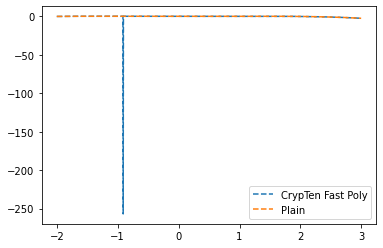

In [17]:
from math import log2, ceil
import numpy as np

# coeffs = [0.11328125, 0.5, 0.41015625, 0., -0.05078125, 0.]
coeffs = [ 0, 0., 0.17578125, 0., -0.05078125]

@mpc.run_multiprocess(world_size=2)
def evalulate_poly_with_coeffs(x, coeffs):

    x_enc = crypten.cryptensor(x, ptype=crypten.mpc.arithmetic)
    ans = x_enc.eval_poly(coeffs)

    return ans.get_plain_text()

@mpc.run_multiprocess(world_size=2)
def normal_evalulate_poly_with_coeffs(x, coeffs):
    # assert len(coeffs)==5, "Only for degree=4, for now"
    x_enc = crypten.cryptensor(x, ptype=crypten.mpc.arithmetic)
    x2 = x_enc * x_enc
    x4 = x2 * x2
    ans = coeffs[0] + coeffs[1] * x_enc + coeffs[2] * x2 + coeffs[4] * x4
    return ans.get_plain_text()

def get_range(start, end, step):
    return [start + i * step for i in range(int(ceil(end-start)/step))]

INCREMENT=2**(-8)
LOW=-2
HIGH=2+INCREMENT
x_input=get_range(LOW, HIGH, INCREMENT)
# x_input = get_range(-2, 2.25, 0.25)

crypten_fast_poly = evalulate_poly_with_coeffs(x_input, coeffs)[0]
# crypten_fast_poly_cropped = evalulate_poly_with_coeffs(x_input, coeffs+[0.])[0]
crypten_normal_poly = normal_evalulate_poly_with_coeffs(x_input, coeffs)[0]
plain_poly = [sum([x**i * coeffs[i] for i in range(len(coeffs))]) for x in x_input]

# for i in range(len(x_input)):
#     print("In: %3.2f - Crypten Fast Poly: %6.3f - Crypten Normal Poly: %6.3f - Plain: %6.3f" % (x_input[i], crypten_fast_poly[i].item(), crypten_normal_poly[i].item(), plain_poly[i]))
#     print("In: %3.2f - Crypten Fast Poly: %6.3f - Plain: %6.3f" % (x_input[i], crypten_fast_poly[i].item(), plain_poly[i]))

OPACITY=1
from matplotlib import pyplot as plt 
plt.plot(x_input, crypten_fast_poly, "--", label='CrypTen Fast Poly', alpha=OPACITY)
# plt.plot(x_input, crypten_normal_poly, "--", label='CrypTen Normal Poly', alpha=OPACITY)
plt.plot(x_input, plain_poly, "--", label='Plain', alpha=OPACITY)
# plt.plot(x_input, crypten_fast_poly_cropped, "--", label='CrypTen Fast Poly Cropped', alpha=OPACITY)
plt.legend()
plt.show()
